### Preparation

* [`numpy`](http://www.numpy.org) is a module for scientific computing (i.e. *vector* and *matrix* processing) with Python.
* [`matplotlib`](https://matplotlib.org) is a module for plotting.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [188]:
from operator import mul
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
plt.style.use('fivethirtyeight')

## An example

Let us look at a hypothetical appartment rent data. We will take a look only at the price per square meter ($m^2$): `price = w0 * 1  + w1 * square_meters`. We call `price` a response variable; in literature usually denoted as $y$. We call `square_meters` a predictor variable. We call `w0` and `w1` weights - it is basically *intercept* and *slope* of a line. `w0` has a special meaning and is called a `bias`. In our example we can interpret it as base fixed price you would pay for 0 sqaure meters of living area.

Here is a graph that visualizes a price with 200 CU (currency units) base price and 10 CU increase per square meter: `price = 200 + 10 * square_meters`. We also add some *observations*, i.e., some data that we read in a finctional announce or whereever. These data points have some *noise* - factors that we cannot account for. For example some renters may have good or bad negotiation skills that will make the price vary around the line.  

(0, 2000)

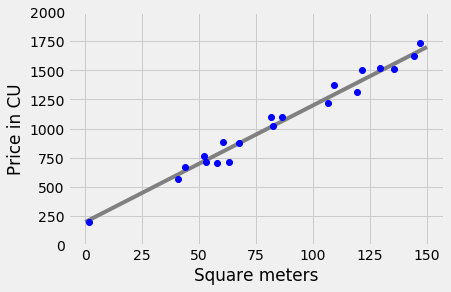

In [201]:
square_meters = np.linspace(0, 150)
price = 200 + 10 * square_meters

# a random number between 0 and 1 will be multiplied by 150 to
# kind of represent a spectrum of square meters.
number_of_points = 20
random_square_meters_data = np.random.sample(size = number_of_points) * 150
price_with_noise = 200 + 10 * random_square_meters_data + np.random.normal(size = number_of_points, scale = 50)

# plot data
_ = plt.plot(square_meters, price, color = 'grey')
_ = plt.plot(random_square_meters_data, price_with_noise, 'o', color = 'blue')
_ = plt.xlabel('Square meters')
_ = plt.ylabel('Price in CU')
plt.ylim(0, 2000)
plt.show()

The data here has one dimension: the square meters. But we rarely have only one-dimensional data (also see [problems with many dimensions](https://en.wikipedia.org/wiki/Curse_of_dimensionality)). For example, square meters are actually two variables: length and width. We can also add height as a third dimension that may be an additional influence to the price. So is the city, weather and anything else. We usually abstract from the actual names and simly call dimensions by their numbered variable: dimension $i$ is simply encoded in variable $x_i$. For example $x_1$ is `length`, $x_2$ is `width`, $x_3$ is `height` and so on. *Bias* has usually a special notation: $x_0$. We almost always need to take care for *bias* variable and we will do it down bellow.

We now have a conceptual understanding of dimensions and can jump into coding stuff.

The goal of the following is to explain how basic regression works. 

Imagine we have gathered 20 samples of 'data' where for each price (response) we have `length`, `width`, `height`, and `distance` from downtown (predictors).


The weights influence the price as follows: we have `basic_price` ($w_0$), `length` ($x_1$), `width` ($x_2$), `height` ($x_3$), `distance` ($x_4$), and the last one `square_meters` ($x_5$). Thus the price results from the following: 
$$price = w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 + w_3 \cdot x_3 + w_4 \cdot x_4 + w_5 \cdot x_5$$

In [283]:
weights = (np.random.uniform(size = 6) + 1) * [200, .5, .7, 1.5, -.05, 3.5]
weights

array([234.48,   0.9 ,   1.12,   1.6 ,  -0.1 ,   6.2 ])

In [415]:
n_samples = 20
np.set_printoptions(2, suppress=True)
tmp = np.column_stack((1.5 + np.random.sample(size = n_samples) * 10, # length
                       1.5 + np.random.sample(size = n_samples) * 10, # width
                       np.round(2   + np.random.sample(size = n_samples) * 2, decimals=1), # height
                       np.random.sample(size = n_samples) * 3000)) # distance from center in meters
samples_data_X = np.column_stack((tmp, tmp[:,0]*tmp[:,1])) # square meters
del(tmp)
samples_data_X

array([[   9.79,   10.02,    3.4 , 1079.76,   98.11],
       [   5.05,    7.24,    2.6 , 2590.9 ,   36.57],
       [   6.75,    8.92,    2.2 , 1119.08,   60.21],
       [   4.93,    9.27,    3.2 ,  923.96,   45.68],
       [   4.76,    6.57,    3.1 , 2153.28,   31.26],
       [   9.66,    3.73,    2.6 ,  916.65,   36.06],
       [   6.17,    3.06,    2.  ,  660.73,   18.86],
       [   5.1 ,    1.91,    3.  , 1146.55,    9.77],
       [   9.26,    6.69,    3.2 , 2524.12,   61.97],
       [   7.35,   10.17,    2.2 , 1837.65,   74.71],
       [   6.94,    7.38,    3.5 , 1117.13,   51.26],
       [   4.24,    8.85,    3.5 , 2649.96,   37.55],
       [   2.2 ,   10.8 ,    3.3 , 1071.2 ,   23.77],
       [   9.53,    6.69,    2.2 , 1566.95,   63.76],
       [  10.46,    4.94,    2.6 ,  171.51,   51.69],
       [   6.98,   11.22,    3.3 , 2312.03,   78.32],
       [   5.34,    4.46,    3.6 , 1136.33,   23.82],
       [   2.78,    6.95,    2.2 ,  470.58,   19.29],
       [   8.87,    6.85,   

In [416]:
samples_data_price_Y = np.dot(np.column_stack((np.ones(samples_data_X.shape[0]), samples_data_X)), weights)
# we add some noise to the response that adds unpredictable variance to the price.
samples_data_price_Y = samples_data_price_Y + np.random.normal(scale = 2.5, size = np.prod(samples_data_price_Y.shape))
samples_data_price_Y

array([757.63, 221.06, 513.17, 447.49, 233.6 , 385.17, 300.84, 191.62,
       389.38, 537.03, 463.67, 224.98, 292.3 , 498.25, 557.63, 513.48,
       285.83, 323.92, 568.81, 257.66])


Let's say, we want to find *weights* of a *linear model* to predict the price of an offer (the six $w_i$ from the equation above). Meaning we got data from a makler that send us data for `length=10`, `width=10`, `height=3`. Furthermore we looked at some map data and got the `distance=3044` meters from downtown. The makler didn't tell us the price yet - but lets see if we can estimate the price by ourselfes. In such a way we will go into negotiations and can back up our claims with data.

Having gathered the data, we compute the following:

$$\mathbf{\hat{w}} = (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^T \mathbf{y} $$

In [417]:
bold_X = np.column_stack((np.ones(samples_data_X.shape[0]), samples_data_X))
estimated_weights = np.dot(np.dot(np.linalg.inv(np.dot(bold_X.T, bold_X)), bold_X.T), samples_data_price_Y)
estimated_weights
weights

array([238.78,   0.94,   0.79,   0.78,  -0.1 ,   6.19])

array([234.48,   0.9 ,   1.12,   1.6 ,  -0.1 ,   6.2 ])

Looks like the estimated weight from noisy data are not so far off. Of course we wouldn't know the true weights in reality. And so, we would have to bargain with a makler for a price around:

In [420]:
np.round(np.dot(estimated_weights, [1, 10, 10, 3, 3044, 10*10]), 2) 

577.44

### Here be dragons

**What is this matrix vodoo above? And why does it looks like it looks like?**

We will derive the above equation based on amazingly clear [tutorial of Mark L. J. Orr](https://www.cc.gatech.edu/~isbell/tutorials/rbf-intro.pdf). And we will do it in the least mathematical way possible - mostly with **code**.

## Appendix A.1

A *vector* is simply an array of $n$ numbers $\mathbf{x}^T = [x_1, x_2, \ldots, x_n]$. The number $n$ represents the number of *dimensions*. The T-operator $\cdot^T$ simply tells us to treat the vector as a *column* vector - more to that in a second.

In [167]:
x = np.arange(5)
x

array([0, 1, 2, 3, 4])

A matrix is simply a 'collection' of vectors with the same dimension. Most of the time the matrix will have $m$ number of rows and $n$ number of columns. 

**Example**: We want to have two (2) arrays. Each of array contains five (5) numbers, i.e., is a 5-dimensional vector. The resulting matrix has $m=2$ rows and $n=5$ columns. 

In [202]:
v1 = np.arange(1, 6)
v1
v2 = np.arange(1, 6) * 2
v2
simple_matrix = np.stack([v1, v2])
simple_matrix

array([1, 2, 3, 4, 5])

array([ 2,  4,  6,  8, 10])

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10]])

For computational purpuses we seldomly use $x$ as single vector. Instead we treat it as *row* entry in a matrix, i.e. as a *row vector*. Hence, in matrix notation, a vector has one (1) row and $n$ columns. (This is usually denoted as a *tuple* `(1, n)`)

In [21]:
v1 = np.reshape(np.arange(1,6), (1,5))
v1

array([[1, 2, 3, 4, 5]])

Remember our T-operator? Now, if we use $\cdot^T$ it will *[T]ranspose* the matrix, i.e. rows will be collums and collumns will be rows.

In [22]:
v1.T

array([[1],
       [2],
       [3],
       [4],
       [5]])

The same applies to matrices:

In [171]:
simple_matrix = np.stack([v1, v2])
simple_matrix
simple_matrix.T

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10]])

array([[ 1,  2],
       [ 2,  4],
       [ 3,  6],
       [ 4,  8],
       [ 5, 10]])

Which bring us directly to matrix and vector operations. We denote a $k$-th vector with bold $\mathbf{x}_k$ (e.g. vector 1 is $\mathbf{x}_1$). We denote a matrix with a bold capital letter, for example $M$. As discussed, to access $j$-th vector (i.e. $\mathbf{x}_j$) and $i$-th value (value in dimension $i$) of a vector in this matrix

In [ ]:
* vector

In [103]:
def get_y(x, weights, bias = 0, noise_scale = 0):
    noise = 0
    if noise_scale > 0:
        noise = np.random.normal(size = 1)
    return np.sum(x*weights + bias + noise) 

In [132]:
weights = np.random.normal(5, size = 5, scale = 10)
weights

array([-1.29, 12.04, 10.98,  1.48, 18.23])

In [421]:
dim = (1000, len(weights))
x_mat = np.reshape((np.random.uniform(size = np.prod(dim)) - 0.5) * 10, dim)

In [422]:
%timeit y = np.apply_along_axis(get_y, 1, x_mat, weights = weights)
y[0:5]
%timeit y = np.dot(x_mat, weights) + np.random.normal(scale = 25, size = x_mat.shape[0])
y[0:5]

20.4 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


array([ 28.66,  76.15,  62.29, -16.53,  95.53])

62.2 µs ± 552 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


array([ 28.66,  76.15,  62.29, -16.53,  95.53])

In [146]:
np.dot(np.dot(np.linalg.inv(np.dot(x_mat.T, x_mat)), x_mat.T), y)

array([-1.3 , 12.06, 10.97,  1.42, 18.26])

In [84]:
np.linalg.inv(np.dot(x_mat.T, x_mat))

array([[ 2.40e-05,  8.17e-08, -1.88e-07,  3.96e-07, -2.67e-07],
       [ 8.17e-08,  2.40e-05,  2.78e-07,  3.18e-07,  1.96e-07],
       [-1.88e-07,  2.78e-07,  2.37e-05, -4.83e-07,  3.26e-07],
       [ 3.96e-07,  3.18e-07, -4.83e-07,  2.41e-05,  4.79e-07],
       [-2.67e-07,  1.96e-07,  3.26e-07,  4.79e-07,  2.42e-05]])

## Runtime information

Numpy, BLAS, and LAPACK.

In [423]:
np.__file__
np.__version__
np.show_config()

'/home/burkovae/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'

'1.14.2'

mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/burkovae/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/burkovae/anaconda3/include']
blas_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/burkovae/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/burkovae/anaconda3/include']
blas_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/burkovae/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/burkovae/anaconda3/include']
lapack_mkl_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/burkovae/anaconda3/lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['/home/burkovae/anaconda3/include']
lapack_opt_info:
    libraries = ['mkl_rt', 'pthread']
    library_dirs = ['/home/burkovae/anac

In [166]:
%%bash
ldd ~/anaconda3/lib/python3.6/site-packages/numpy/core/multiarray.cpython-36m-x86_64-linux-gnu.so

	linux-vdso.so.1 =>  (0x00007ffdbcd95000)
	libmkl_rt.so => /home/burkovae/anaconda3/lib/python3.6/site-packages/numpy/core/../../../../libmkl_rt.so (0x00007f9659959000)
	libpthread.so.0 => /lib/x86_64-linux-gnu/libpthread.so.0 (0x00007f965973c000)
	libm.so.6 => /lib/x86_64-linux-gnu/libm.so.6 (0x00007f9659433000)
	libc.so.6 => /lib/x86_64-linux-gnu/libc.so.6 (0x00007f9659069000)
	/lib64/ld-linux-x86-64.so.2 (0x00007f965a399000)
	libdl.so.2 => /lib/x86_64-linux-gnu/libdl.so.2 (0x00007f9658e65000)
